# Project 6 : Ocean warming contribution to Sea level rise

*Victor BERCY & Quentin RIBAUD*

Sea level increases because of changes in currents (dynamic effect) and because of ocean density changes (steric effect). Compute ocean density changes contribution to Sea level rises (thermosteric effect) and demonstrate that it is the driver of regional sea level change trends.

## Objectives

- Quantitatively determine where and by how much the ocean is warming or cooling (pattern of sea level warming) over the past few years
- Quantitatively determine where and by how much the ocean is rising (pattern of sea level rise) over the past few years
- Connect these two last patterns

Specific region of the globe chosen to better caracterise the ocean heat content : Pacific Ocean, North-East Australia : -10° N 160° E

Temperature : use the Ocean Heat Content (OHC in Joules)
Sea level : use the Dynamic Height Anomaly (DHA in Meters)

## Context

- Dynamic effect : variation of the sea level due to the currents
- Steric effect : evolution of the sea level to thermal expansion and salinity variations
- Thermosteric effect : as temperature of the ocean increases, the volume of sea water increases and can produce a higher sea level

Globally, the ocean is warming and the sea level is rising. However, the local evolution can be specific in some regions over the globe, which can be explained by the steric changes of sea level due to changes in the local heat content in the ocean.

## Preliminaries

### Install dependencies

In [ ]:
!pip install --upgrade dask distributed xarray zarr gcsfs cftime nc-time-axis intake intake-xarray

In [ ]:
!pip install gsw
!pip install cartopy

### Import libraries

- matplotlib (2D plotting)
- pylab (scientific computing)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)
- xarray (N-D labeled arrays and datasets)

In [ ]:
%matplotlib inline
%pylab inline

from gsw import cp_t_exact, geostrophy as gsy, conversions as conv
import cartopy.crs as ccrs

import xarray as xr
from intake import open_catalog

import pandas as pd
from scipy.stats.mstats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import multiprocessing as mp

import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(10,10) # graph size

Populating the interactive namespace from numpy and matplotlib


### Ploting functions

### Access and listing of the catalog

In [ ]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2022/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)
list(cat)

['argo_global_sdl',
 'argo_global_sdl_homogeneous',
 'argo_global_vertical_mean',
 'en4',
 'sea_surface_height']

### Connect to data

Description of the dataset :

Contains the salinity (plus total weighting given to the observation increments and standard deviation of the measure) and the temperature (plus idem) for locations all over the globe and at different depths

In [ ]:
#Access EN4 dataset (interpolation of all available ocean observations of temperature and salinity onto a regular space/time grid)

from intake import open_catalog
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2022/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url) 
ds_en4 = cat["en4"].to_dask()
print("Size of the dataset:", ds_en4.nbytes/1e9,"Gb")
ds_en4

Size of the dataset: 52.2317975 Gb


<xarray.Dataset>
Dimensions:                          (depth: 42, time: 832, bnds: 2, lat: 173, lon: 360)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(832, 2), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.0
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    GDS_version_id:         v1.7
    contact:                Simon Good - simon.good@metoffice.gov.uk
    creation_date:          2017-04-21 21:12:08.123 -00:00
    easternmost_longitude:  362.5
    ...                     ...
    start_date:             2001-01-01 UTC
    start_time:             00:00:00 UTC
    stop_date:              2001-01-01 UTC
    stop_time:              00:00:00 UTC
    title:                  Temperature and salinity analysis
    westernmost_longitude:  0.5

Let's visualize the temperature over the entire globe at two different depths at a specific date

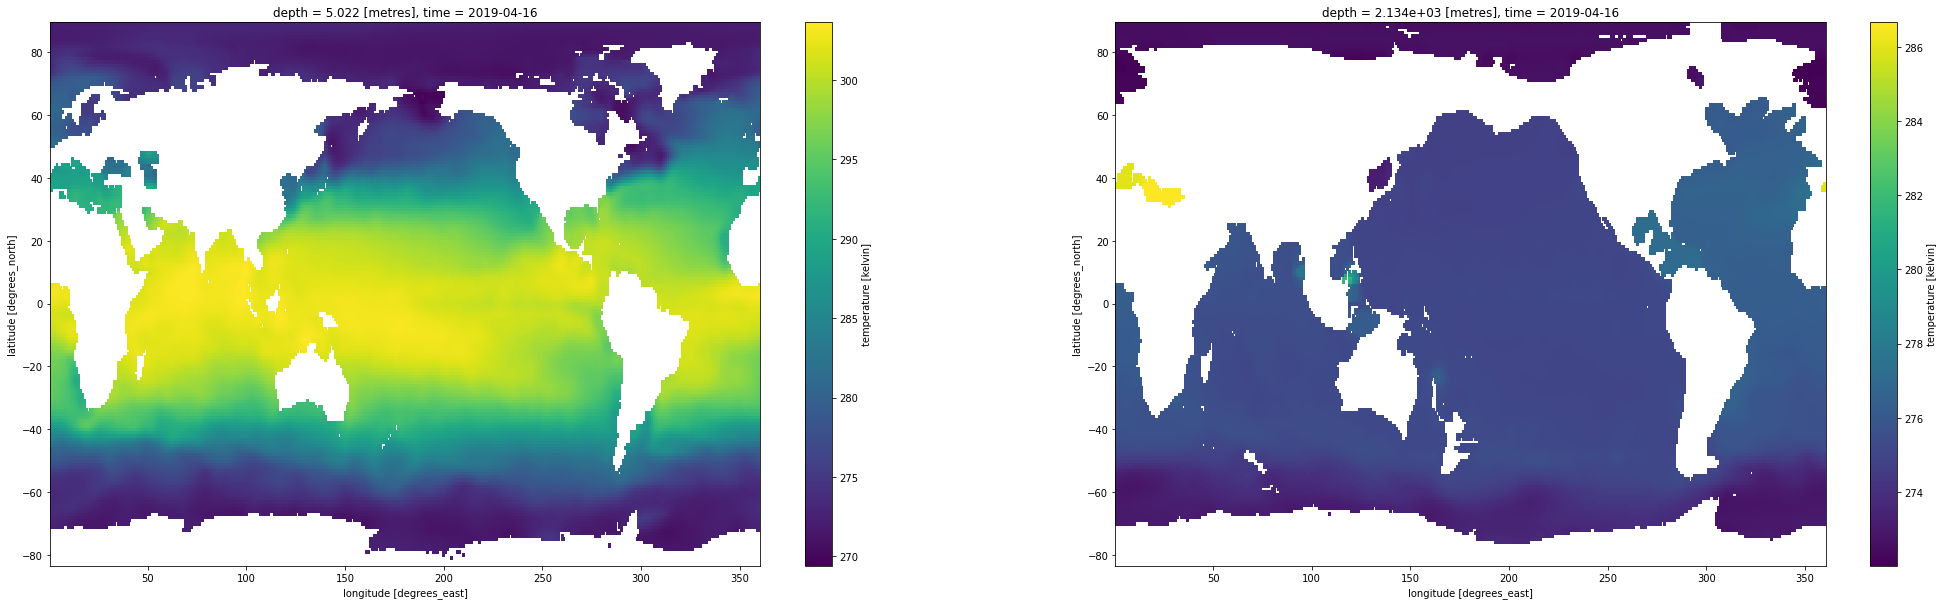

In [ ]:
figure(figsize=(35,10))
subplot(121)
ds_en4['temperature'].isel(time=831, depth=0).plot()
subplot(122)
ds_en4['temperature'].isel(time=831, depth=30).plot()

Let's visualize the salinity over the entire globe at two different depths at a specific date

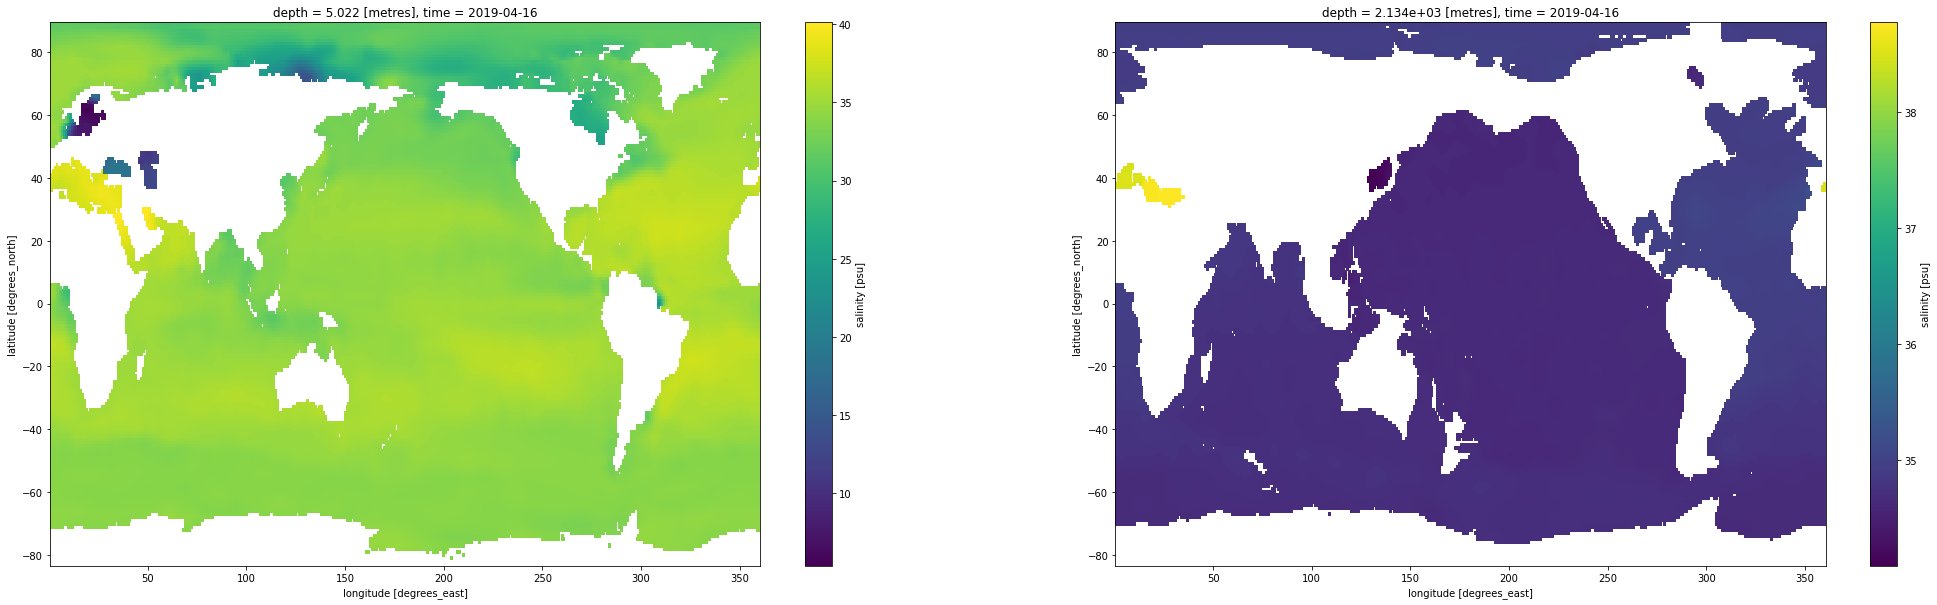

In [ ]:
figure(figsize=(35,10))
subplot(121)
ds_en4['salinity'].isel(time=831, depth=0).plot()
subplot(122)
ds_en4['salinity'].isel(time=831, depth=30).plot()

Description of the dataset :

Contains different measures of the sea level (see scheme below) and of the currents for locations all over the globe and at different depths

In [ ]:
#Access Sea Level data on the catalog as well

ds_sealvl = cat["sea_surface_height"].to_dask()
print("Size of the dataset:", ds_sealvl.nbytes/1e9,"Gb")
ds_sealvl

Size of the dataset: 18.1203746 Gb


<xarray.Dataset>
Dimensions:    (time: 312, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2018-12-01
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    crs        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds   (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Note:                            Generated by G. Maze with 31 daily files
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-31T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1993-01-30T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

Explanatory scheme :

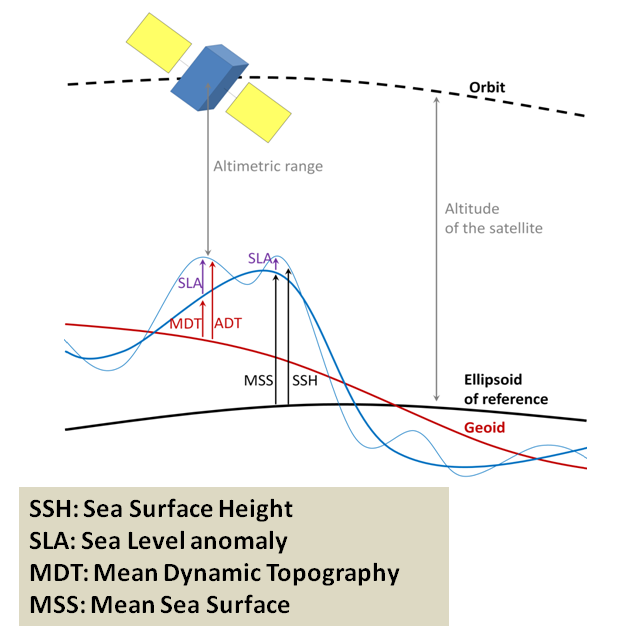
<br>[Source](https://duacs.cls.fr/faq/what-are-the-product-specification/different-sea-surface-heights-used-in-altimetry/)

Let's visualize the ADT value over the entire globe at two different dates

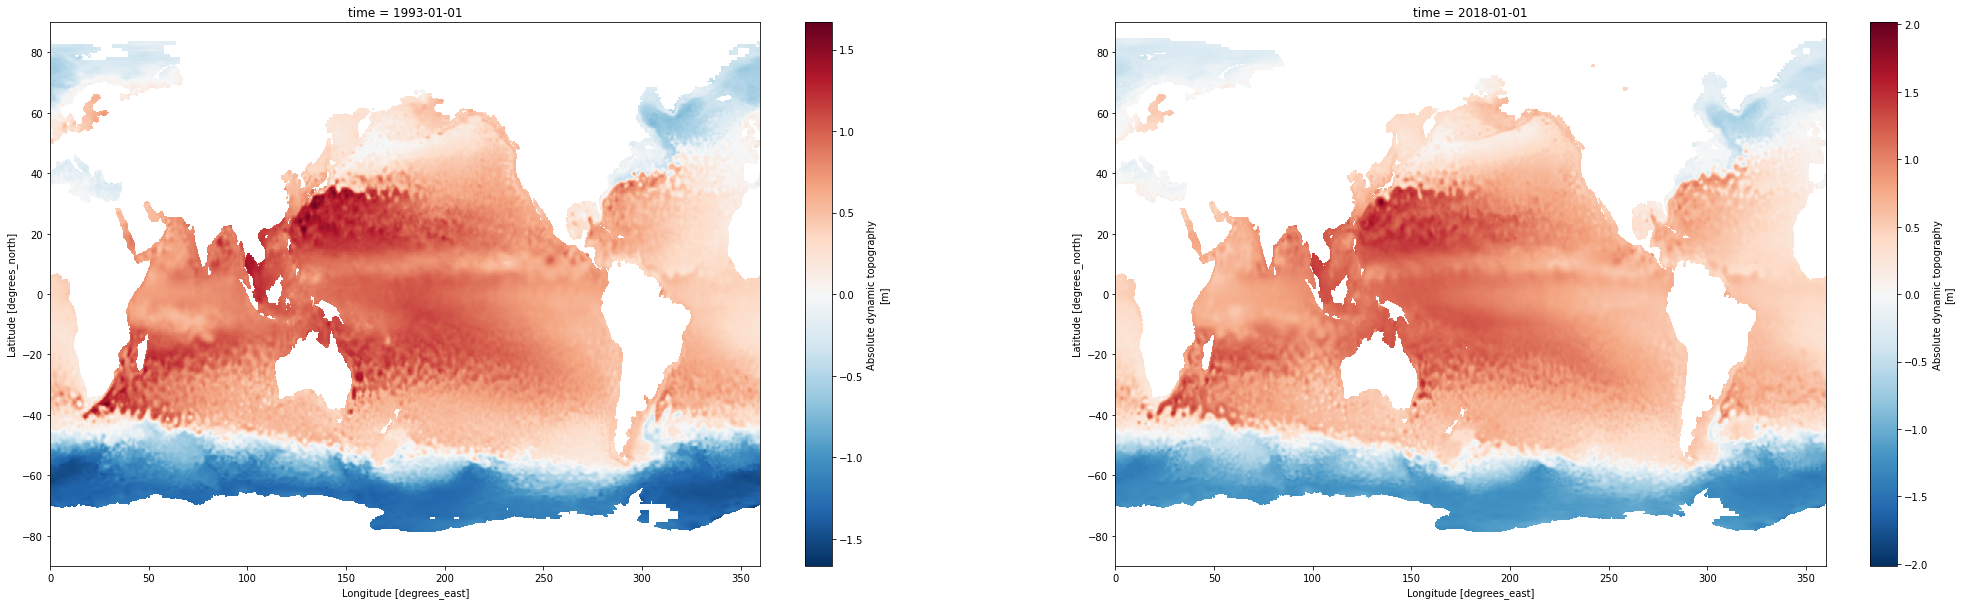

In [ ]:
figure(figsize=(35,10))
subplot(121)
ds_sealvl['adt'].isel(time=0).plot()
subplot(122)
ds_sealvl['adt'].isel(time=300).plot()

## Introduction

Manipulating and reshaping the dataset, visualize the evolution of some variables through the years (temperature, absolute dynamic topography)

### Computing temporal mean and chunking both datasets

In [ ]:
#Resampling the data (to have less data to manipulate) by computing the mean of every value each 5 years
ds_en4_5years = ds_en4.resample(time='5y').mean()
ds_en4_5years

<xarray.Dataset>
Dimensions:                          (time: 15, depth: 42, bnds: 2, lat: 173, lon: 360)
Coordinates:
  * time                             (time) datetime64[ns] 1950-12-31 ... 202...
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>

In [ ]:
#Convert Kelvin to °C
ds_en4_5years['temperature'] = ds_en4_5years['temperature'] - 273.15

In [ ]:
#Chunking the dataset to allows the parallelisation of xarray if needed
ds_en4_chunked = ds_en4_5years.chunk({"time": 1, "lat": 45, "lon": 45})
del ds_en4_5years
ds_en4_chunked.chunks

Frozen({'time': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'depth': (42,), 'bnds': (2,), 'lat': (45, 45, 45, 38), 'lon': (45, 45, 45, 45, 45, 45, 45, 45)})

In [ ]:
#Get the duration (in years) between the last and the first measure of the dataset en4
date_min = ds_en4['time'].isel(time=0).values
date_max = ds_en4['time'].isel(time=831).values
dur_en4 = date_max - date_min
dur_en4 = dur_en4.astype(int) / (10**9 * 3600 * 24 * 365.25)

In [ ]:
#Resampling the data (to have less data to manipulate) by computing the mean of every value each 2 years
ds_sealvl_2years = ds_sealvl.resample(time='2y').mean()
ds_sealvl_2years

<xarray.Dataset>
Dimensions:    (time: 14, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
  * time       (time) datetime64[ns] 1993-12-31 1995-12-31 ... 2019-12-31
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    crs        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds   (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

In [ ]:
#Chunking the dataset to allows the parallelisation of xarray if needed
ds_sealvl_chunked = ds_sealvl_2years.chunk({"time": 1, "latitude": 45, "longitude": 90})
del ds_sealvl_2years
ds_sealvl_chunked.chunks

Frozen({'time': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'latitude': (45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45), 'longitude': (90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90), 'nv': (2,)})

In [ ]:
#Get the duration (in years) between the last and the first measure of the dataset sealvl
date_min = ds_sealvl['time'].isel(time=0).values
date_max = ds_sealvl['time'].isel(time=311).values
dur_sealvl = date_max - date_min
dur_sealvl = dur_sealvl.astype(int) / (10**9 * 3600 * 24 * 365.25)

### Evolution of the sea surface temperature

In [ ]:
#Compute the trend of the sea surface temperature over the entire period provided by the dataset
diff_temp = (ds_en4_chunked['temperature'].isel(time=14) - ds_en4_chunked['temperature'].isel(time=0)) / dur_en4
diff_temp

<xarray.DataArray 'temperature' (depth: 42, lat: 173, lon: 360)>
dask.array<truediv, shape=(42, 173, 360), dtype=float32, chunksize=(42, 45, 45), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03

Let's visualize the mean sea surface temperature at two different periods

Text(0.5, 1.0, 'Mean sea surface temperature (°C) between 2016 and 2020')

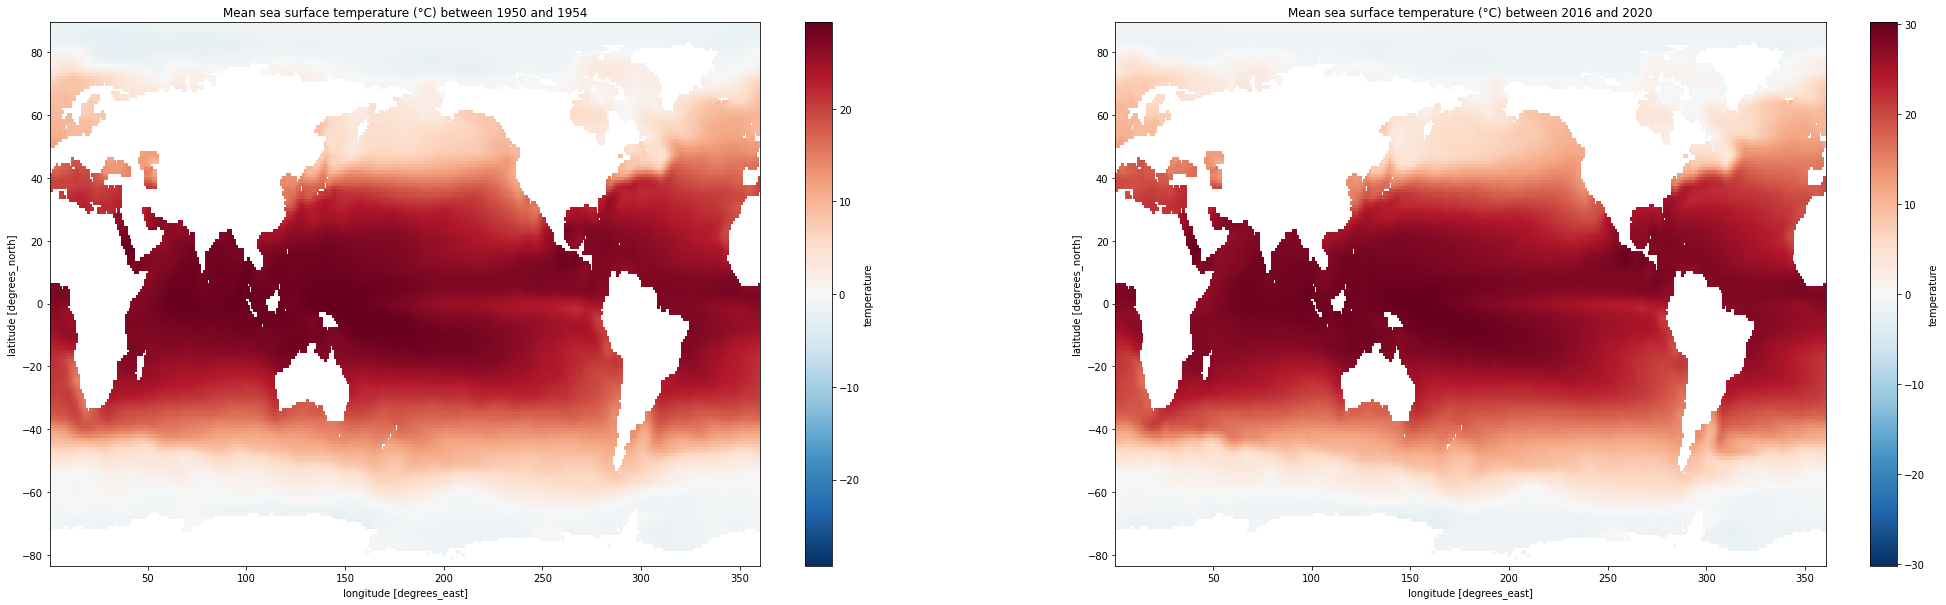

In [ ]:
figure(figsize=(35,10))
subplot(121)
ds_en4_chunked['temperature'].isel(time=0, depth=0).plot()
title("Mean sea surface temperature (°C) between 1950 and 1954")
subplot(122)
ds_en4_chunked['temperature'].isel(time=14, depth=0).plot()
title("Mean sea surface temperature (°C) between 2016 and 2020")

Text(0.5, 1.0, 'Sea surface temperature trend (°C/year) between the period 2016-2020 and the period 1950-1954')

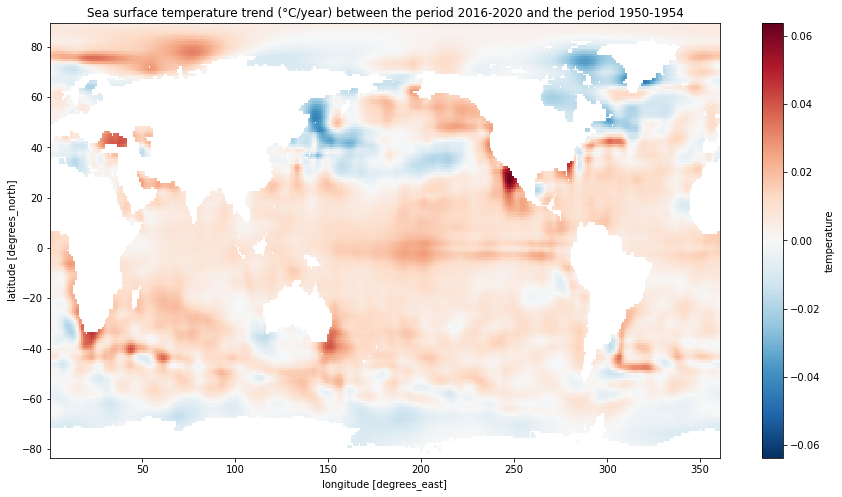

In [ ]:
figure(figsize=(15,8))
diff_temp.isel(depth=0).plot()
title("Sea surface temperature trend (°C/year) between the period 2016-2020 and the period 1950-1954")

We can see below that the sea surface temperature increases the most around the equator. Some regions where it increases the most can be highlighted : West coast of the United States, South of the Indian Ocean, South-East of the Australia.

However, we can also observe regions where the sea surface temperature has decreased since 1950, like the East coast of Russia.

### Evolution of the sea level

In [ ]:
#Compute the trend of the absolute dynamic topography over the entire period provided by the dataset
diff_adt = (ds_sealvl_chunked['adt'].isel(time=5) - ds_sealvl_chunked['adt'].isel(time=0)) / dur_sealvl
diff_adt

<xarray.DataArray 'adt' (latitude: 720, longitude: 1440)>
dask.array<truediv, shape=(720, 1440), dtype=float64, chunksize=(45, 90), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9

In [ ]:
#Compute the mean dynmamic topography and its trend over the entire period provided by the dataset
ds_sealvl_chunked['mdt'] = ds_sealvl_chunked['adt'] - ds_sealvl_chunked['sla']
diff_mdt = (ds_sealvl_chunked['mdt'].isel(time=5) - ds_sealvl_chunked['mdt'].isel(time=0)) / dur_sealvl
diff_mdt

<xarray.DataArray 'mdt' (latitude: 720, longitude: 1440)>
dask.array<truediv, shape=(720, 1440), dtype=float64, chunksize=(45, 90), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9

Text(0.5, 1.0, 'Mean dynamic topography (m) between 2017 and 2018')

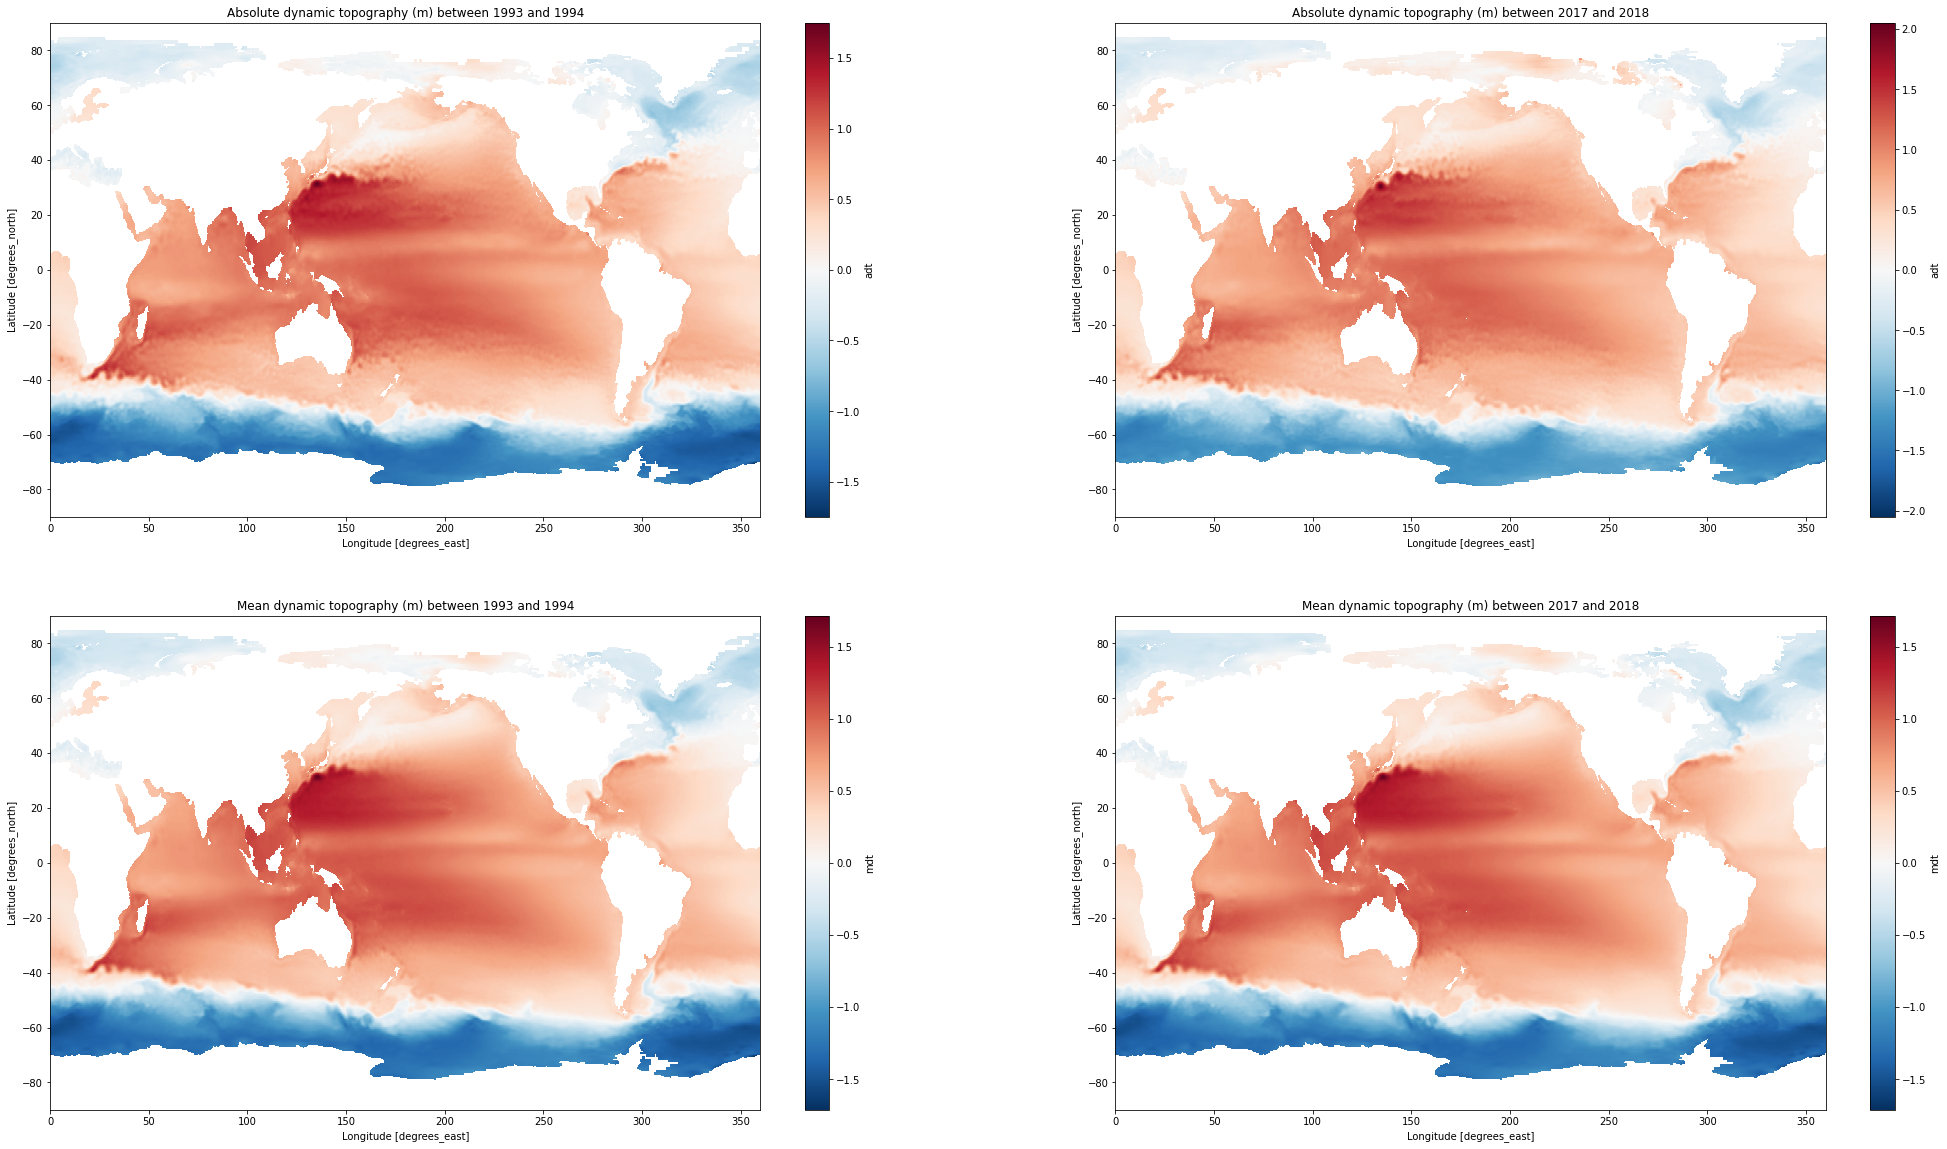

In [ ]:
figure(figsize=(35,20))
subplot(221)
ds_sealvl_chunked['adt'].isel(time=0).plot()
title("Absolute dynamic topography (m) between 1993 and 1994")
subplot(222)
ds_sealvl_chunked['adt'].isel(time=13).plot()
title("Absolute dynamic topography (m) between 2017 and 2018")
subplot(223)
ds_sealvl_chunked['mdt'].isel(time=0).plot()
title("Mean dynamic topography (m) between 1993 and 1994")
subplot(224)
ds_sealvl_chunked['mdt'].isel(time=13).plot()
title("Mean dynamic topography (m) between 2017 and 2018")

We can see here that the Mean and the Absolute Dynamic Topography are as high as the other is in every region in the world...

Text(0.5, 1.0, 'Mean dynamic topography (m/year) between the period 2017-2018 and the period 1993-1994')

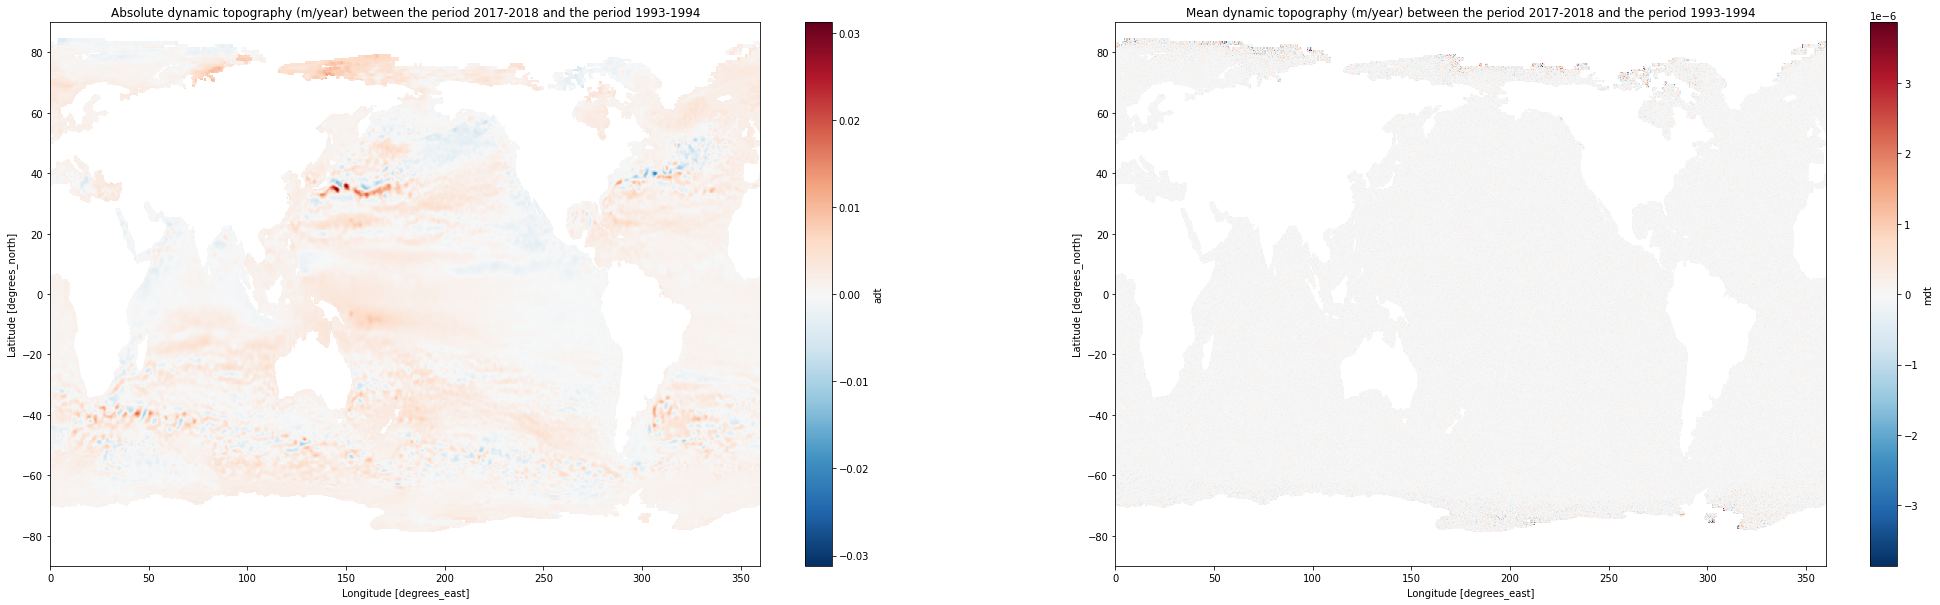

In [ ]:
figure(figsize=(35,10))
subplot(121)
diff_adt.plot()
title("Absolute dynamic topography (m/year) between the period 2017-2018 and the period 1993-1994")
subplot(122)
diff_mdt.plot()
title("Mean dynamic topography (m/year) between the period 2017-2018 and the period 1993-1994")

... however, as we can see below, the MDT seem to be constant over the time. Thus, the ADT will be a better variable to potentially caracterize the link with the ocean warming.

### Spatial sampling

To avoid high computing time, one solution is selecting one point every x points to lower the resolution.

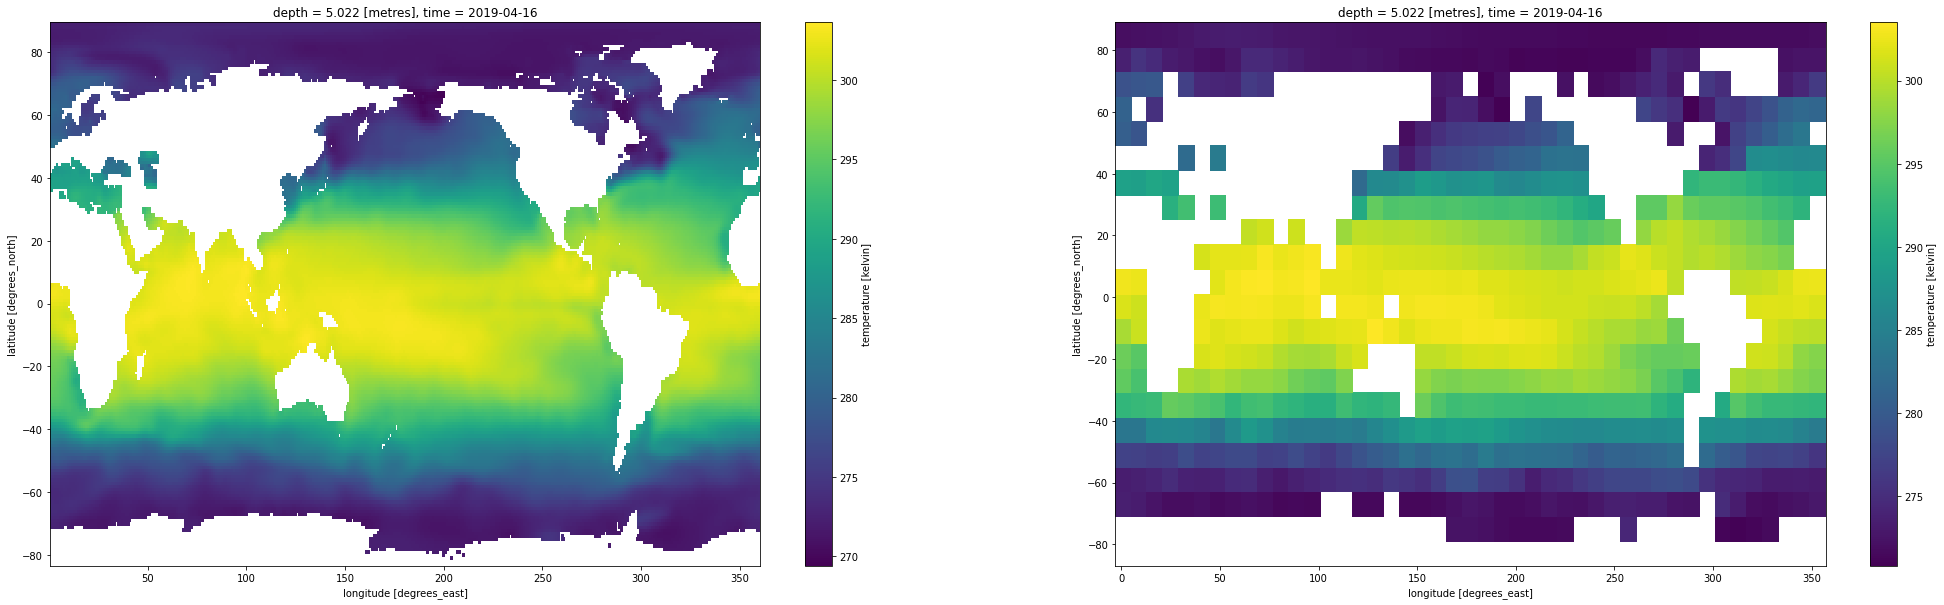

In [ ]:
#Resample the grid of latitudes and longitudes taking one point out of "step"
step = 8
n_lat, n_lon = 173, 360
range_lat, range_lon = range(0,n_lat,step), range(0,n_lon,step)

#Compare before and after sampling on a random variable
figure(figsize=(35,10))
subplot(121)
ds_en4['temperature'].isel(time=831, depth=0).plot()
subplot(122)
ds_en4['temperature'].isel(time=831, depth=0, lat=range_lat, lon=range_lon).plot()

Unfortunately, it was impossible to serial compute the map with enough resolution to obtain precise results.

### Zoom in on a specific region

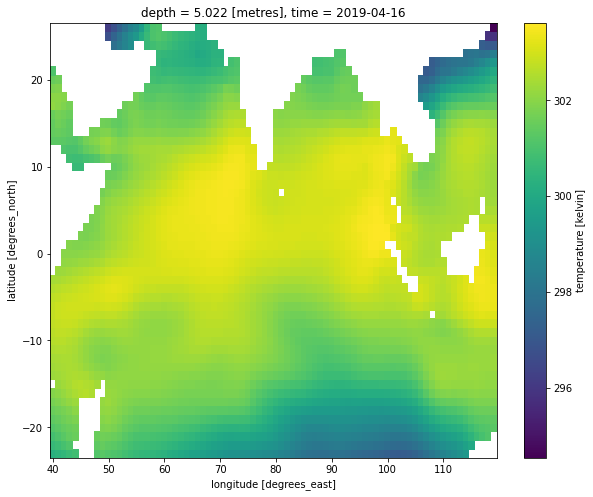

In [ ]:
#Zoom on the Indian Ocean
slice_lon = slice(39, 119)
slice_lat = slice(60, 110)

figure(figsize=(10,8))
ds_en4['temperature'].isel(time=831, depth=0, lat=slice_lat, lon=slice_lon).plot()

This technique seems to be the best to serial compute this variable in certain regions of the world. However we loose the ability to achieve global studies.

## Analyse

Computing more precise variables (dynamic height anomaly, ocean heat content), searching the correlation between these variables

### Linking the data of practical salinity, the in-situ temperature and the ADT

Visualize these three variables seperatly on specific locations of the globe by interpolating the locations of both datasets.

In [ ]:
#Interpolation of the database sealvl on the en4 one through the grid of longitudes and latitudes
ds_interp = ds_sealvl.interp(latitude=ds_en4['lat'], longitude=ds_en4['lon'], method='linear')
ds_interp

<xarray.Dataset>
Dimensions:    (time: 312, lat: 173, lon: 360, nv: 2)
Coordinates:
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2018-12-01
    latitude   (lat) float32 -83.0 -82.0 -81.0 -80.0 ... 86.0 87.0 88.0 89.0
    longitude  (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * lat        (lat) float32 -83.0 -82.0 -81.0 -80.0 ... 86.0 87.0 88.0 89.0
  * lon        (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
Data variables:
    adt        (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    crs        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    err        (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    lat_bnds   (time, lat, nv) float32 dask.array<chunksize=(1, 173, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nv) float32 dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    sla        (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    ugos       (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    ugosa      (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    vgos       (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    vgosa      (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Note:                            Generated by G. Maze with 31 daily files
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-31T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1993-01-30T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.01048468, 0.11048468, 0.21048468, 0.31048468, 0.41048468,
        0.51048468, 0.61048468, 0.71048468, 0.81048468, 0.91048468,
        1.01048468]),
 <a list of 10 Patch objects>)

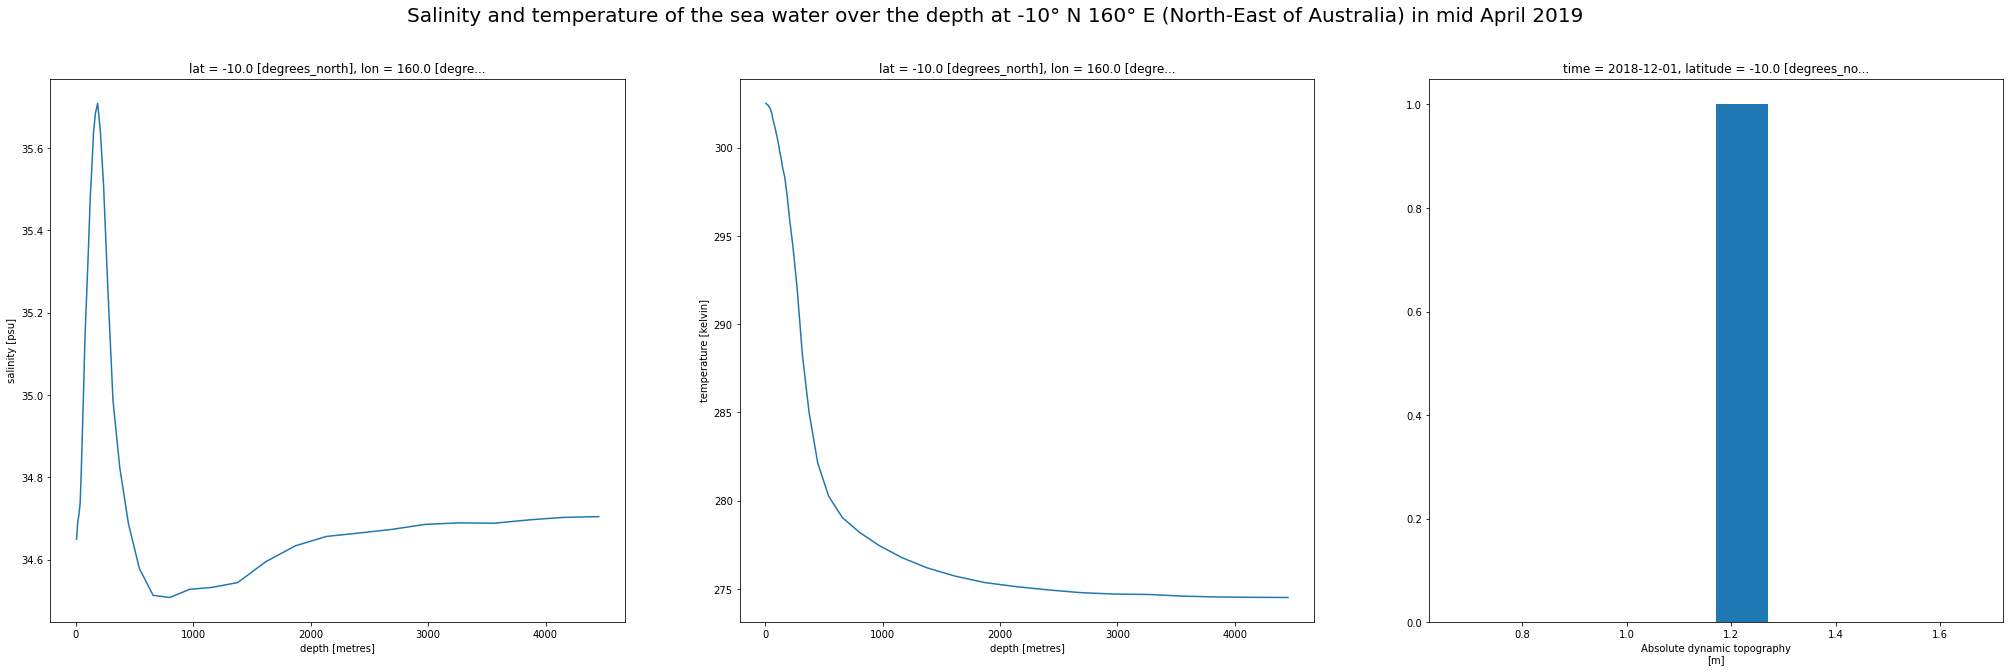

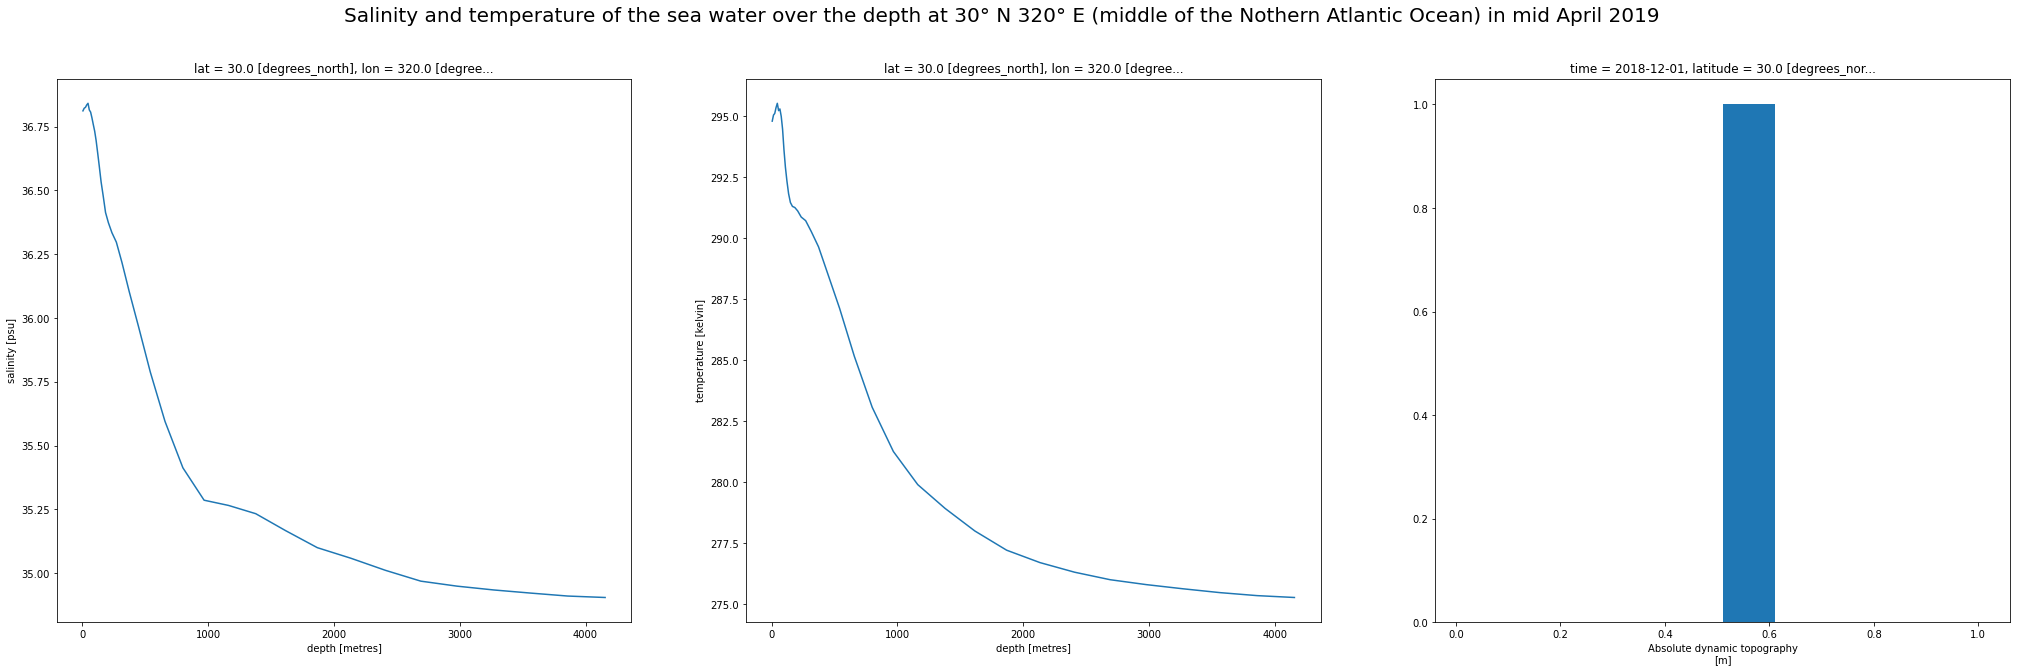

In [ ]:
figure(figsize=(35,10))
suptitle('Salinity and temperature of the sea water over the depth at -10° N 160° E (North-East of Australia) in mid April 2019', fontsize=20)
subplot(131)
ds_en4['salinity'].isel(time=311, lat=73, lon=159).plot()
subplot(132)
ds_en4['temperature'].isel(time=311, lat=73, lon=159).plot()
subplot(133)
ds_interp['adt'].isel(time=311, lat=73, lon=139).plot()

figure(figsize=(35,10))
suptitle('Salinity and temperature of the sea water over the depth at 30° N 320° E (middle of the Nothern Atlantic Ocean) in mid April 2019', fontsize=20)
subplot(131)
ds_en4['salinity'].isel(time=311, lat=113, lon=319).plot()
subplot(132)
ds_en4['temperature'].isel(time=311, lat=113, lon=319).plot()
subplot(133)
ds_interp['adt'].isel(time=311, lat=113, lon=319).plot()

### Steric height



The steric height is the variation of the ocean volume due to density changes (expansion and contraction of water masses). We use the gsw library to compute it.

The steric height seems to be a better variable to highlight the link between the sea level and the ocean warming.

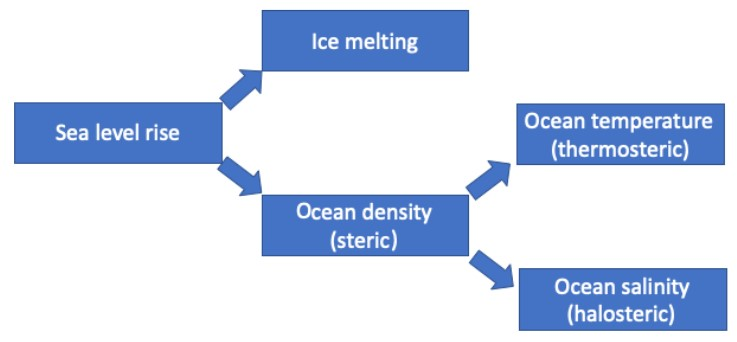

In [ ]:
#Computing the sea pressure (dbar)...
ds_en4_chunked['pressure'] = conv.p_from_z(-1*ds_en4_chunked['depth'], ds_en4_chunked['lat']).transpose('lat', 'depth').expand_dims(
    {'lon' : ds_en4_chunked['lon']}).where(ds_en4_chunked['temperature'] == ds_en4_chunked['temperature']).transpose('time', 'depth', 'lat', 'lon')

#... the absolute salinity (g/kg)...
ds_en4_chunked['SA'] = conv.SA_from_SP(ds_en4_chunked['salinity'], ds_en4_chunked['pressure'], ds_en4_chunked['lon'], ds_en4_chunked['lat'])

#...  and the conservative temperature (°C)
ds_en4_chunked['CT'] = conv.CT_from_t(ds_en4_chunked['SA'], ds_en4_chunked['temperature'], ds_en4_chunked['pressure'])

ds_en4_chunked

<xarray.Dataset>
Dimensions:                          (time: 15, depth: 42, bnds: 2, lat: 173, lon: 360)
Coordinates:
  * time                             (time) datetime64[ns] 1950-12-31 ... 202...
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    pressure                         (time, depth, lat, lon) float64 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    SA                               (time, depth, lat, lon) float64 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    CT                               (time, depth, lat, lon) float64 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>

Number of CPU cores :

In [ ]:
!nproc

2


In [ ]:
#Computing the dynamic height anomaly as a function of pressure for points all over the globe
#Computing time : 15s for ground locations, 45s for sea locations

from time import time

#Resample the grid of latitudes and longitudes taking one point out of "step"
step = 32
n_lat, n_lon = 173, 360
range_lat, range_lon = range(0,n_lat,step), range(0,n_lon,step)

g = 9.7963 #m/s^2
        
ds_en4_chunked['steric_height'] = xr.apply_ufunc(gsy.geo_strf_dyn_height,
                                                 ds_en4_chunked['SA'].isel(lat=range_lat, lon=range_lon),
                                                 ds_en4_chunked['CT'].isel(lat=range_lat, lon=range_lon),
                                                 ds_en4_chunked['pressure'].isel(lat=range_lat, lon=range_lon),
                                                 dask='parallelized', output_dtypes=[ds_en4_chunked['SA'].dtype]) / g

ds_en4_chunked['steric_height'].isel(time=0, lat=73, lon=159).compute()

<xarray.DataArray 'steric_height' (depth: 42)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan])
Coordinates:
    lat      float32 -10.0
    lon      float32 160.0
    time     datetime64[ns] 1950-12-31
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03

For an unknown reason, the result is filled from *nan* although we use the same code as the other group (Mario Herrera Gonzalez & Joséphine Schmutz).

--> see the code of the other group

In [ ]:
diff_dha = (ds_en4_chunked['steric_height'].isel(time=14) - ds_en4_chunked['steric_height'].isel(time=0)) / dur_en4
diff_dha

<xarray.DataArray 'steric_height' (depth: 42, lat: 173, lon: 360)>
dask.array<truediv, shape=(42, 173, 360), dtype=float64, chunksize=(42, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03

Text(0.5, 1.0, 'Mean dynamic height anomaly (m) between 2015 and 2019')

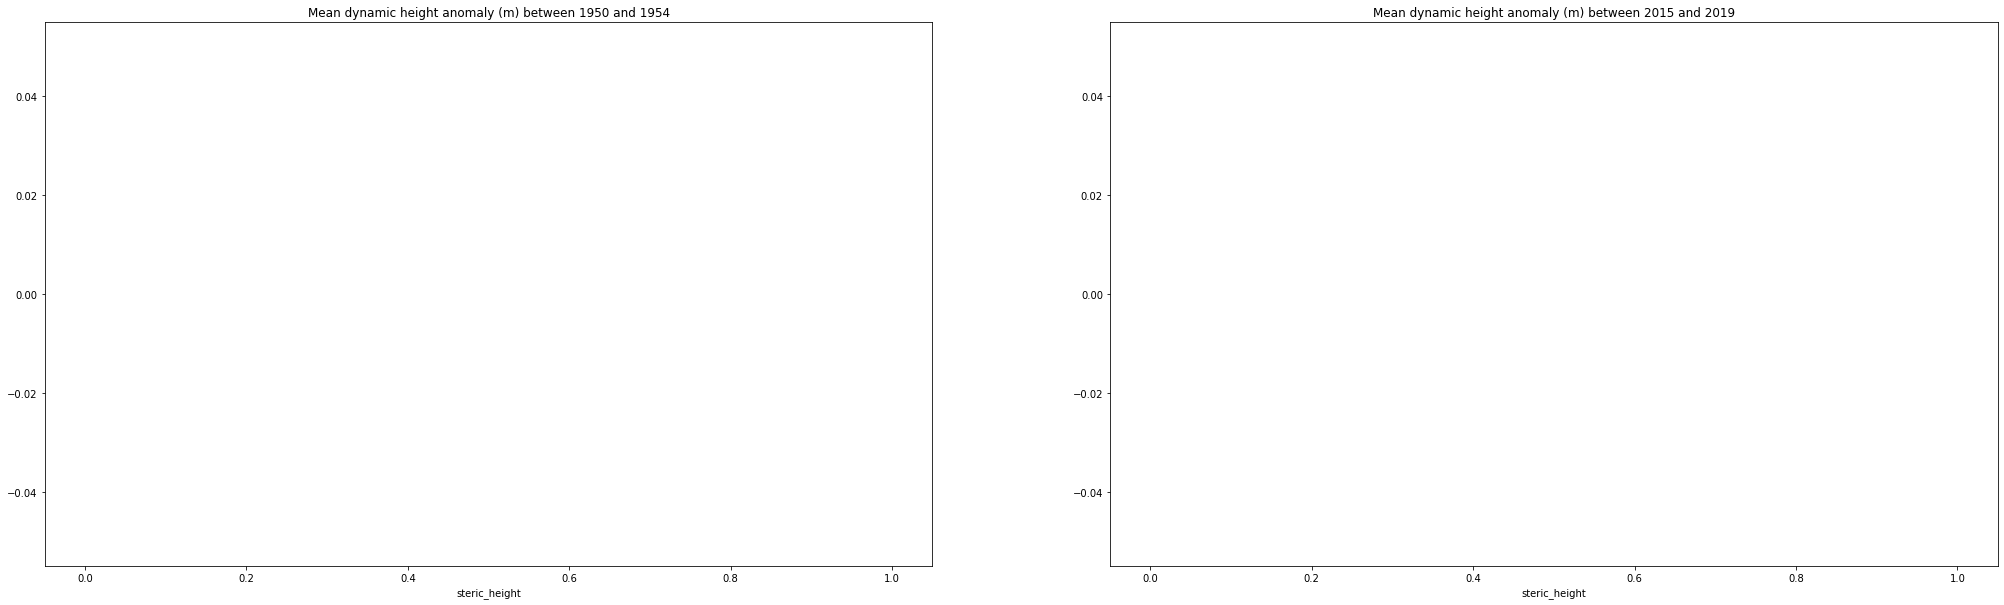

In [ ]:
figure(figsize=(35,10))
subplot(121)
ds_en4_chunked['steric_height'].isel(time=0).plot()
title("Mean dynamic height anomaly (m) between 1950 and 1954")
subplot(122)
ds_en4_chunked['steric_height'].isel(time=14).plot()
title("Mean dynamic height anomaly (m) between 2015 and 2019")

Text(0.5, 1.0, 'Dynamic height anomaly trend (m/year) between the period 2015-2019 and the period 1950-1954')

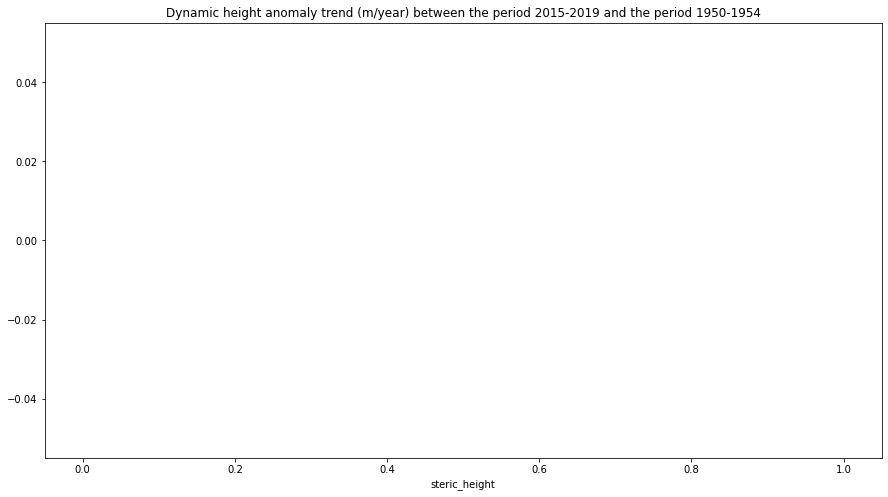

In [ ]:
figure(figsize=(15,8))
diff_dha.plot()
title("Dynamic height anomaly trend (m/year) between the period 2015-2019 and the period 1950-1954")

### Ocean heat content (OHC)

Finding the measuring step of depth of the database en4.

Text(0.5, 1.0, 'Value to add to the actual depth to obtain the depth of the next measure')

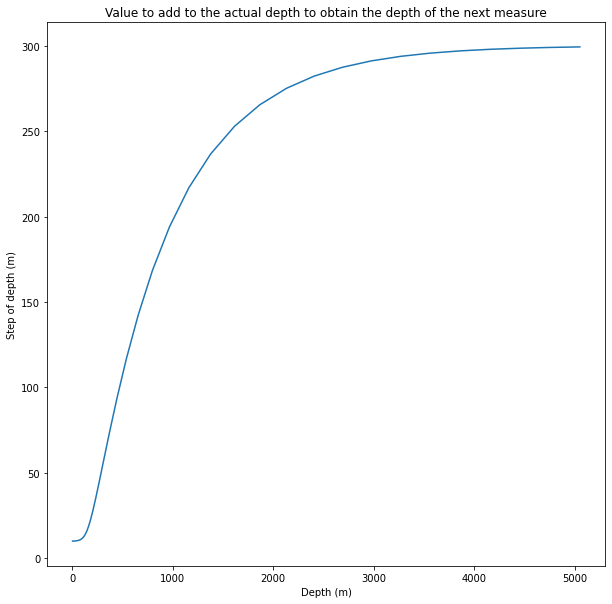

In [ ]:
#Convert the axis of depth in array and computing the difference of the consecutive elements
depth_array = ds_en4_chunked['depth'].values
depth_scale = ediff1d(depth_array)

#Ploting the result
plot(depth_array[:-1], depth_scale)
xlabel("Depth (m)")
ylabel("Step of depth (m)")
title("Value to add to the actual depth to obtain the depth of the next measure")

In [ ]:
rho = 1025 #Sea water density (kg/m3)
cp = cp_t_exact(ds_en4_chunked['SA'], ds_en4_chunked['temperature'], ds_en4_chunked['pressure']).isel(depth=0) #Specific sea water capacity (J.kg-1.K-1)
T = ds_en4_chunked['temperature'].values

cp

<xarray.DataArray 'SA' (time: 15, lat: 173, lon: 360)>
dask.array<getitem, shape=(15, 173, 360), dtype=float64, chunksize=(1, 45, 45), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * time     (time) datetime64[ns] 1950-12-31 1955-12-31 ... 2020-12-31
    depth    float32 5.022

In [ ]:
def heat_content(cp, rho, T, depth_scale):
  '''
  Compute the ocean heat content from numpy arrays
  '''
  integ_T = nansum((T[:,:-1,:,:] - T[:,1:,:,:]) * depth_scale[None,:,None,None], axis=1)
  OHC = cp * rho * integ_T
  return xr.broadcast(OHC, ds_en4_chunked['temperature'])[0]

In [ ]:
#Compute the ocean heat content all around the world at different times
OHC = heat_content(cp, rho, T, depth_scale)

dims = ('time', 'depth', 'lat', 'lon')
ds_en4_chunked['OHC'] = OHC.transpose(*dims)
ds_en4_chunked

<xarray.Dataset>
Dimensions:                          (lat: 173, lon: 360, time: 15, depth: 42, bnds: 2)
Coordinates:
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-12-31 ... 202...
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    pressure                         (time, depth, lat, lon) float64 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    SA                               (time, depth, lat, lon) float64 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    CT                               (time, depth, lat, lon) float64 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>
    steric_height                    (time, depth, lat, lon) float64 dask.array<chunksize=(1, 42, 64, 64), meta=np.ndarray>
    OHC                              (time, depth, lat, lon) float64 dask.array<chunksize=(1, 42, 45, 45), meta=np.ndarray>

In [ ]:
#Compute the ocean heat content trend over the entire period provided by the dataset
diff_OHC = (ds_en4_chunked['OHC'].isel(time=14, depth=0) - ds_en4_chunked['OHC'].isel(time=0, depth=0)) / dur_en4
diff_OHC

<xarray.DataArray 'OHC' (lat: 173, lon: 360)>
dask.array<truediv, shape=(173, 360), dtype=float64, chunksize=(45, 45), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
    depth    float32 5.022

Text(0.5, 1.0, 'Mean ocean heat Content (J.m-2) between 2016 and 2020')

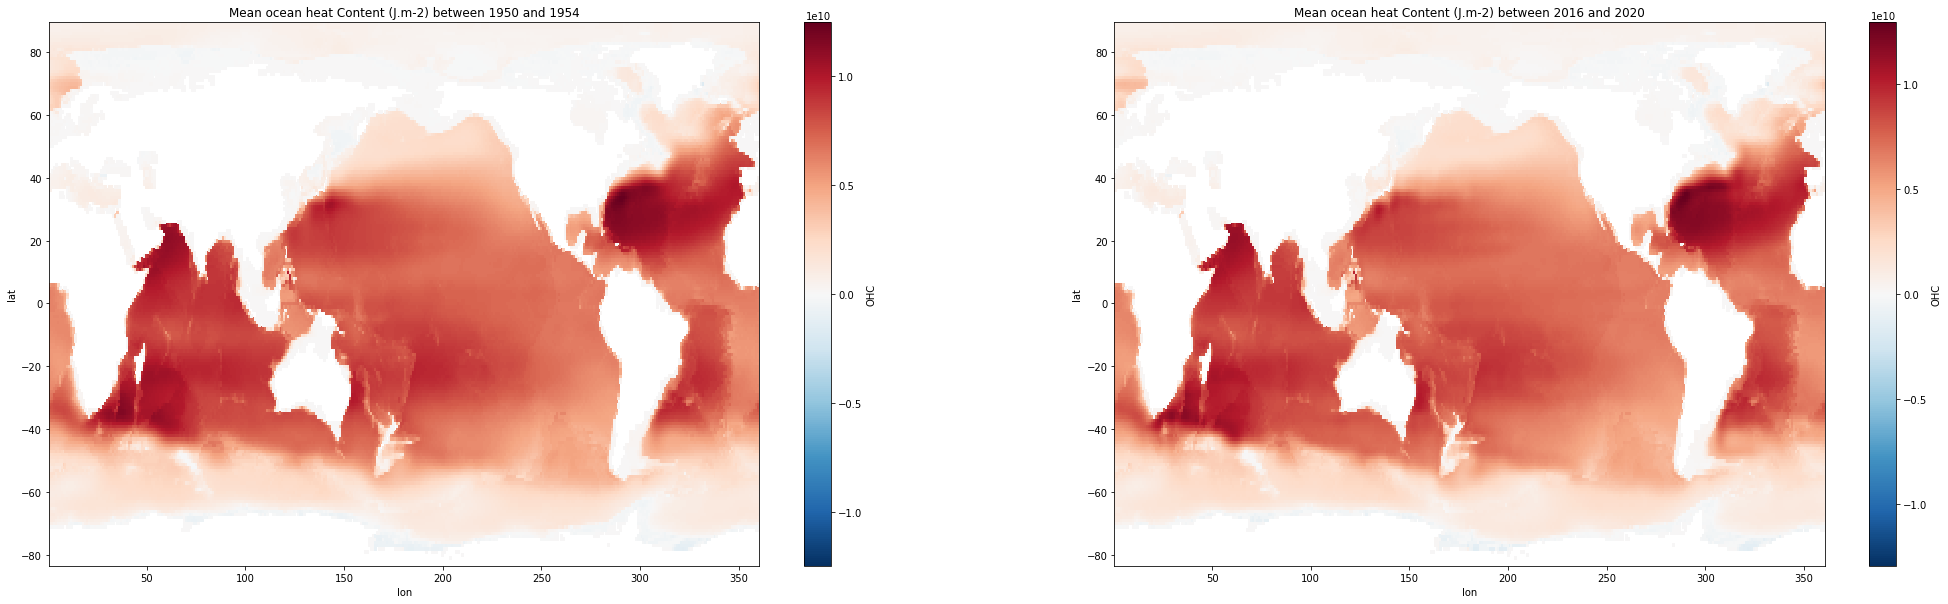

In [ ]:
figure(figsize=(35,10))
subplot(121)
ds_en4_chunked["OHC"].isel(time=0, depth=0).plot()
title("Mean ocean heat Content (J.m-2) between 1950 and 1954")
subplot(122)
ds_en4_chunked["OHC"].isel(time=14, depth=0).plot()
title("Mean ocean heat Content (J.m-2) between 2016 and 2020")

Text(0.5, 1.0, 'Ocean heat content trend (J.m-2/year) between the period 1950-1954 and the period 2016-2020')

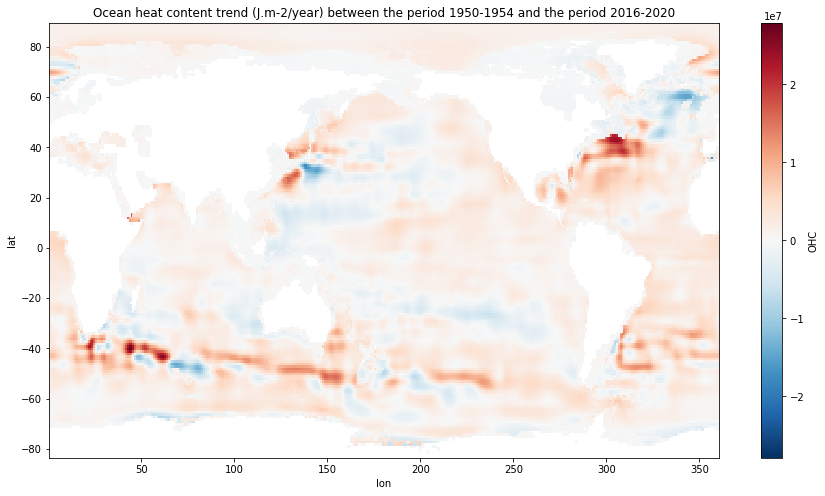

In [ ]:
figure(figsize=(15,8))
diff_OHC.plot()
title("Ocean heat content trend (J.m-2/year) between the period 1950-1954 and the period 2016-2020")

Unlike the temperature, we can see below that the ocean heat content does not increase the most on the equator but practically globally. We can observe regions where it increases the most : South of the Indian Ocean, East coast of Japan, East coast of Canada.

Plotting the evolution in time of the OHC by meaning on the depth and over the globe

Text(0.5, 1.0, 'Mean evolution of the Ocean heat content (J.m-2) over the time')

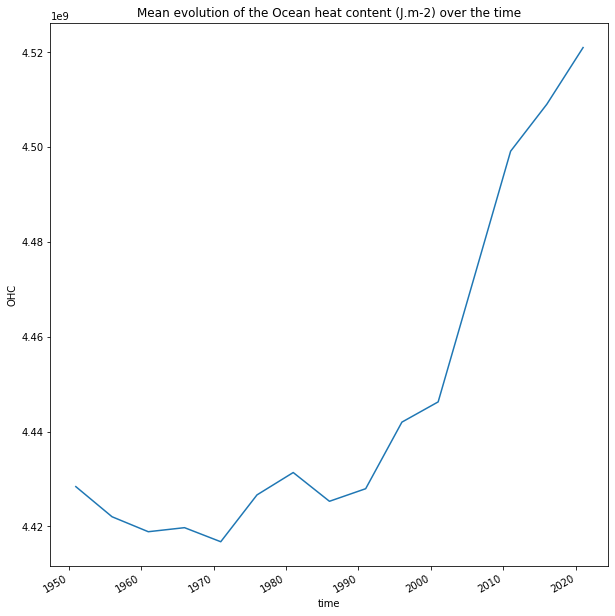

In [ ]:
ds_en4_chunked['OHC'].mean(dim=('lon', 'lat')).isel(depth=0).plot()
title("Mean evolution of the Ocean heat content (J.m-2) over the time")

### Temperature and OHC

To compare directly the temperature and tehe OHC to observe the difference.

Text(0.5, 1.0, 'Mean ocean heat Content (J.m-2) between 2016 and 2020')

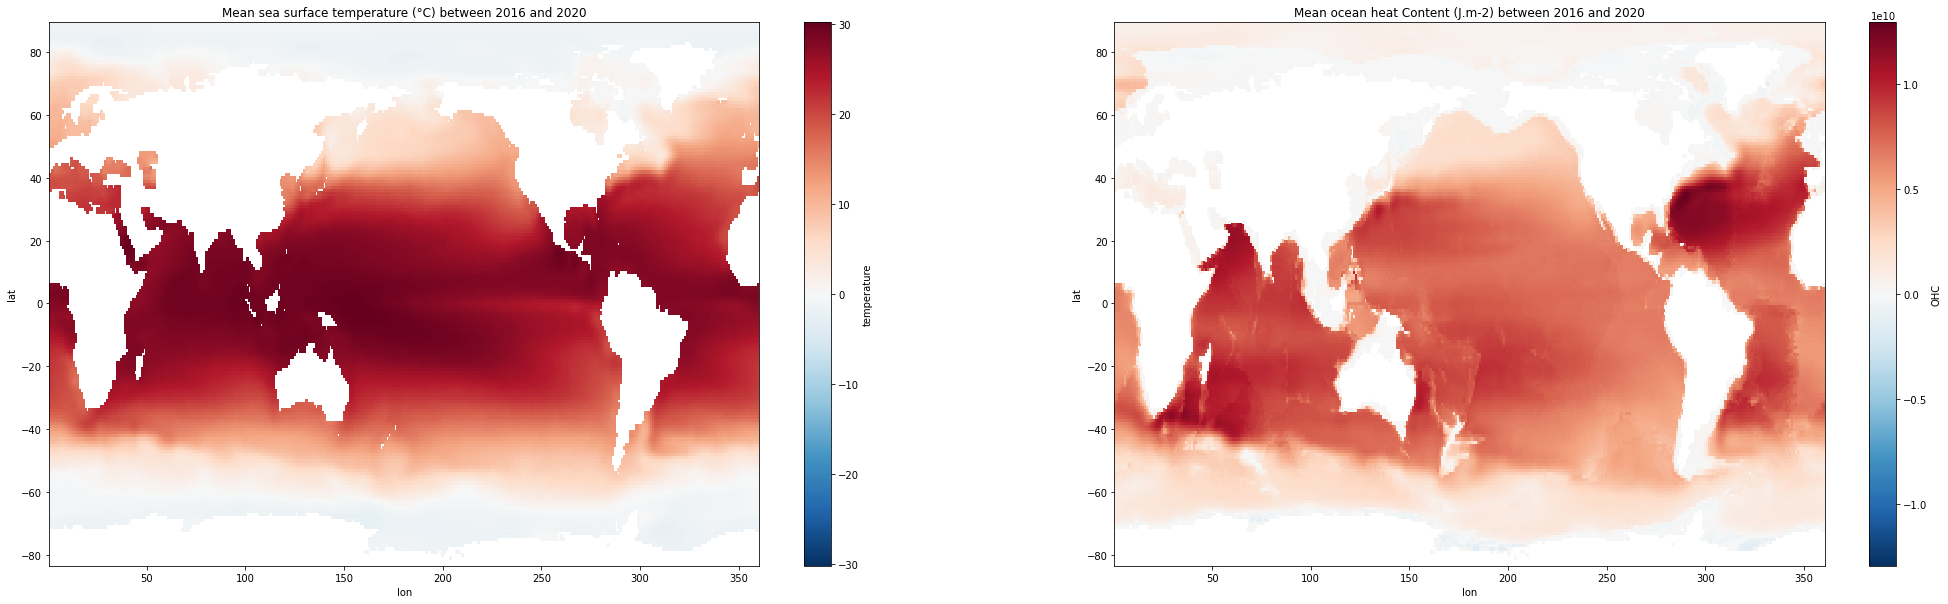

In [ ]:
figure(figsize=(35,10))
subplot(121)
ds_en4_chunked["temperature"].isel(time=14, depth=0).plot()
title("Mean sea surface temperature (°C) between 2016 and 2020")
subplot(122)
ds_en4_chunked["OHC"].isel(time=14, depth=0).plot()
title("Mean ocean heat Content (J.m-2) between 2016 and 2020")

In [ ]:
#Compute the temperature trend over the entire period provided by the dataset
diff_temp = (ds_en4_chunked['temperature'].isel(time=14, depth=0) - ds_en4_chunked['temperature'].isel(time=0, depth=0)) / dur_en4
diff_temp

<xarray.DataArray 'temperature' (lat: 173, lon: 360)>
dask.array<truediv, shape=(173, 360), dtype=float32, chunksize=(45, 45), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
    depth    float32 5.022

Text(0.5, 1.0, 'Ocean heat content trend (J.m-2/year) between the period 1950-1954 and the period 2016-2020')

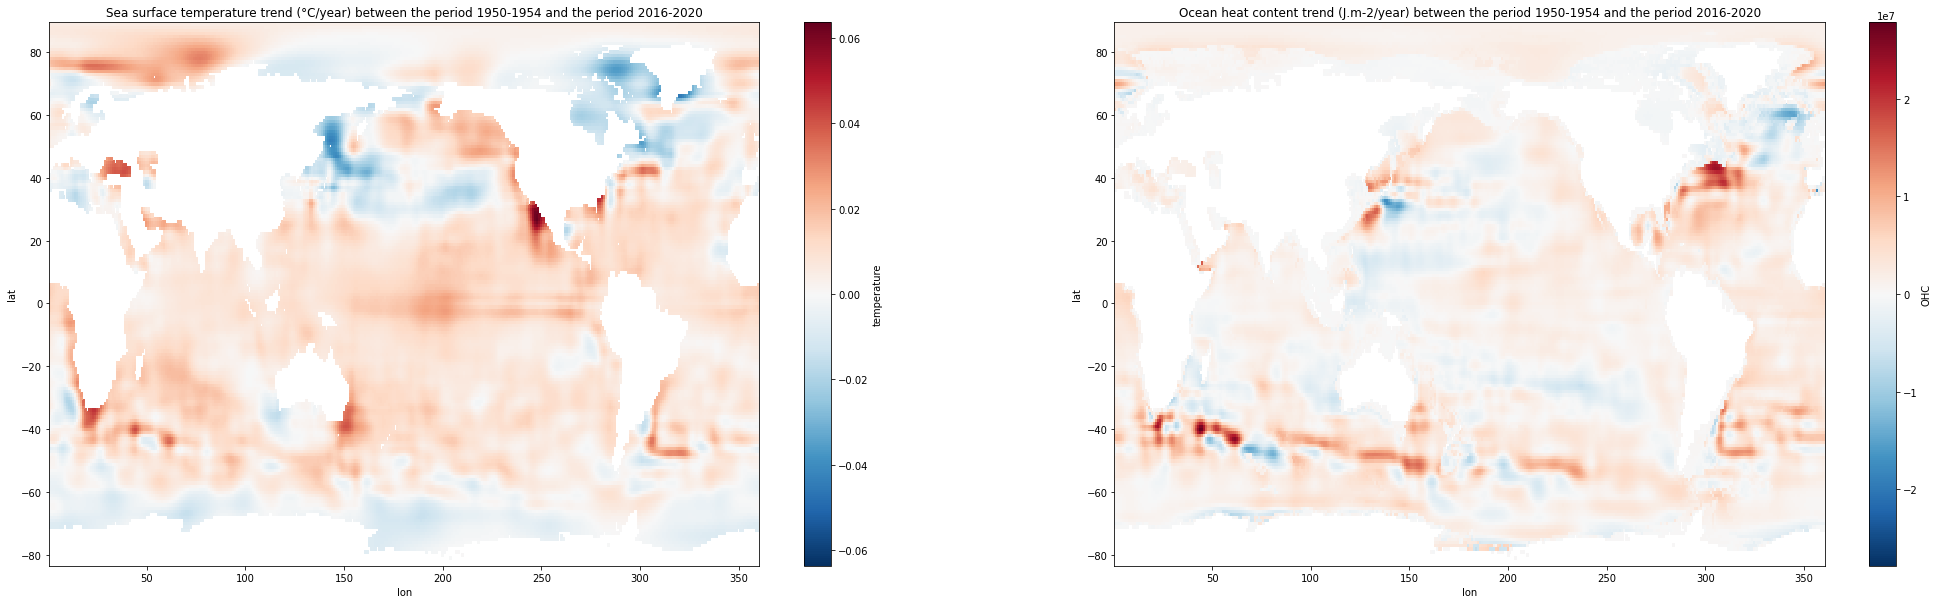

In [ ]:
figure(figsize=(35,10))
subplot(121)
diff_temp.plot()
title("Sea surface temperature trend (°C/year) between the period 1950-1954 and the period 2016-2020")
subplot(122)
diff_OHC.plot()
title("Ocean heat content trend (J.m-2/year) between the period 1950-1954 and the period 2016-2020")

As we said below, the regions where the OHC and the temperature increase are not the same. Yet, we can observe common regions like the South of the Indian ocean and the East coast of Argentina.

In [ ]:
corr_temp_OHC = xr.corr(ds_en4_chunked['temperature'], ds_en4_chunked['OHC'], dim='time')
corr_temp_OHC

<xarray.DataArray (depth: 42, lat: 173, lon: 360)>
dask.array<truediv, shape=(42, 173, 360), dtype=float64, chunksize=(42, 45, 45), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03

Text(0.5, 1.0, 'Correlation map between ocean heat content (J.m-2) and the sea surface temperature (°C)')

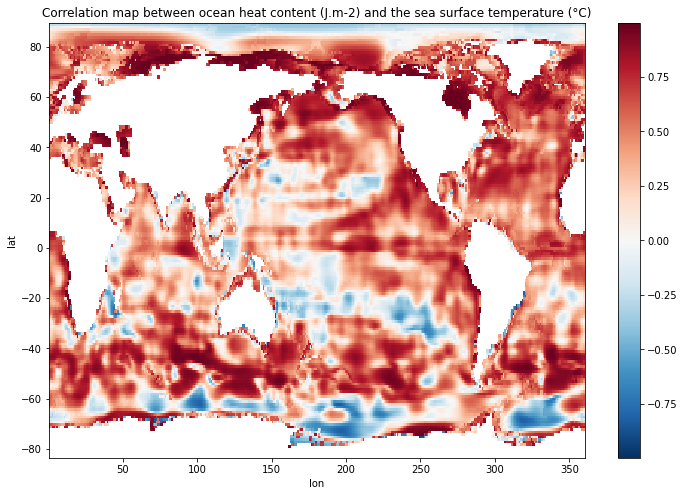

In [ ]:
figure(figsize=(12, 8))
corr_temp_OHC.isel(depth=0).plot()
title("Correlation map between ocean heat content (J.m-2) and the sea surface temperature (°C)")

### Correlation maps

In [ ]:
#Interpolation of the database sealvl on the en4 one through the grid of longitudes and latitudes
ds_interp = ds_sealvl_chunked.interp(latitude=ds_en4_chunked['lat'], longitude=ds_en4_chunked['lon'], method='linear')
ds_interp

<xarray.Dataset>
Dimensions:    (time: 14, lat: 173, lon: 360, nv: 2)
Coordinates:
  * time       (time) datetime64[ns] 1993-12-31 1995-12-31 ... 2019-12-31
  * nv         (nv) int32 0 1
    latitude   (lat) float32 -83.0 -82.0 -81.0 -80.0 ... 86.0 87.0 88.0 89.0
    longitude  (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * lat        (lat) float32 -83.0 -82.0 -81.0 -80.0 ... 86.0 87.0 88.0 89.0
  * lon        (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
Data variables:
    adt        (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    crs        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    err        (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    lat_bnds   (time, lat, nv) float32 dask.array<chunksize=(1, 173, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nv) float32 dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    sla        (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    ugos       (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    ugosa      (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    vgos       (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    vgosa      (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>
    mdt        (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>

ADT and temperature (naive) :

We first compute of naive correlation map with brut data (temperature from the first dataset and adt from the second dataset).

In [ ]:
#Compute the correlation map between the ADT and the temperature over the entire globe
corr_ADT_temp = xr.corr(ds_en4_chunked['temperature'], ds_interp['adt'], dim='time')
corr_ADT_temp

<xarray.DataArray (depth: 42, lat: 173, lon: 360)>
dask.array<truediv, shape=(42, 173, 360), dtype=float64, chunksize=(42, 45, 45), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -83.0 -82.0 -81.0 -80.0 ... 86.0 87.0 88.0 89.0
  * lon        (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * depth      (depth) float32 5.022 15.08 25.16 ... 5.051e+03 5.35e+03
    latitude   (lat) float32 -83.0 -82.0 -81.0 -80.0 ... 86.0 87.0 88.0 89.0
    longitude  (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0

In [1]:
figure(figsize=(12,8))
corr_ADT_temp.isel(depth=0).plot()
title("Correlation map between temperature (°C) and the absolute dynamic topography (m)")

NameError: ignored

Steric height and and OHC

Based on the computation of the OHC and the steric height, we can compute a new correlation map (between OHC and steric height).

In [ ]:
#Open the dataset containing the steric height for all locations around the globe computed by the group of Herrera Gonzalez Mario and Schmutz Joséphine
#One data every 5 years (idem ds_en4_chunked)
st_height = xr.open_dataset('st_height_5years_sp.nc')

In [ ]:
st_height

<xarray.Dataset>
Dimensions:         (time: 15, lat: 173, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 1950-12-31 1955-12-31 ... 2020-12-31
    depth           float32 ...
  * lat             (lat) float32 -83.0 -82.0 -81.0 -80.0 ... 87.0 88.0 89.0
  * lon             (lon) float32 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
Data variables:
    st_height_anom  (time, lat, lon) float64 ...

In [ ]:
#Computing the correlation map between the steric height and the OHC
corr_SH_OHC = xr.corr(st_height['st_height_anom'], ds_en4_chunked['OHC'].isel(depth=0), dim='time')
corr_SH_OHC

<xarray.DataArray (lat: 173, lon: 360)>
dask.array<truediv, shape=(173, 360), dtype=float64, chunksize=(45, 45), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0

Text(0.5, 1.0, 'Correlation map between ocean heat content (J.m-2) and the steric height (m)')

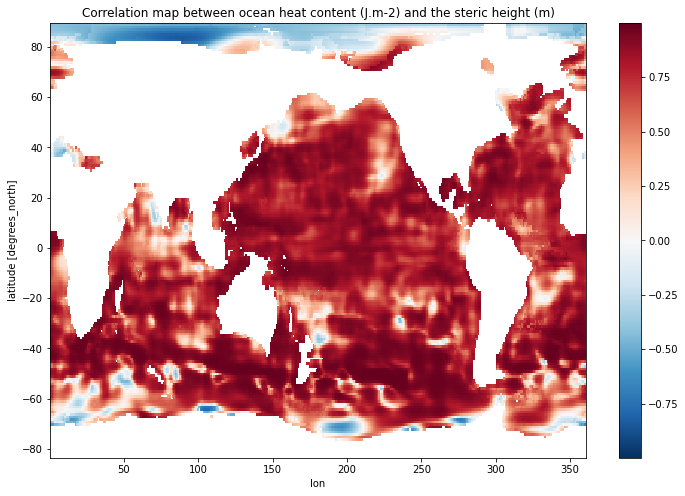

In [ ]:
figure(figsize=(12, 8))
corr_SH_OHC.plot()
title("Correlation map between ocean heat content (J.m-2) and the steric height (m)")

As we can see below, for practically all locations around the globe, the OHC and the steric height are correlated. There are only a few points where the correlation cannot be validated.

As the sea level rise is also due to halosteric effects, we can assume that these points are more impacted by these last type of phenomena. 